In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [40]:
start='2015-01-01'

In [41]:
overall=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
overall

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [42]:
stocks=overall.Symbol

In [43]:
stocks=stocks.to_list()

In [6]:
overall=overall[overall['Date added']>=start]
#only those are relevant after the starting date of the analysis

In [7]:
removed=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1][['Date','Removed']]
removed

Date Removed                          
                  Date  Ticker                  Security
0        April 3, 2024    XRAY           Dentsply Sirona
1        April 3, 2024     VFC            VF Corporation
2        April 2, 2024     NaN                       NaN
3        April 1, 2024     NaN                       NaN
4       March 18, 2024     WHR     Whirlpool Corporation
..                 ...     ...                       ...
339       June 9, 1999     HPH  Harnischfeger Industries
340  December 11, 1998     LDW                     Amoco
341  December 11, 1998     GRN                General Re
342  December 11, 1998     SUN                SunAmerica
343      June 17, 1997     USL                    USLife

[344 rows x 3 columns]

In [8]:
removed=removed.set_index(removed.Date.Date)
removed.index=pd.to_datetime(removed.index)
removed=removed[removed.index>=start]
removed=removed.Removed.dropna()
removed

,Ticker,Security
Date,,
2024-04-03,XRAY,Dentsply Sirona
2024-04-03,VFC,VF Corporation
2024-03-18,WHR,Whirlpool Corporation
2024-03-18,ZION,Zions Bancorporation
2023-12-18,SEE,Sealed Air
...,...,...
2015-03-23,AVP,Avon Products
2015-03-18,CFN,Carefusion
2015-03-12,PETM,PetSmart


In [9]:
stocks.extend(removed.Ticker.to_list())
#include already removed symbols in our analysis

In [44]:
df=yf.download(stocks,start=start)['Close']

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2024-04-06)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [45]:
df.index=pd.to_datetime(df.index)
removed[removed.Ticker=='SBNY'].index[0]

Timestamp('2023-03-15 00:00:00')

In [12]:
df['SBNY'] #Currently we still have prices untill the last day 

Date
2015-01-02    125.250000
2015-01-05    121.809998
2015-01-06    120.360001
2015-01-07    120.970001
2015-01-08    124.080002
                 ...    
2024-04-01      2.300000
2024-04-02      2.300000
2024-04-03      2.550000
2024-04-04      3.050000
2024-04-05      3.180000
Name: SBNY, Length: 2330, dtype: float64

In [13]:
df['SBNY'].index<=removed[removed.Ticker=='SBNY'].index[0]
#filter for dates before the removal date

array([ True,  True,  True, ..., False, False, False])

In [14]:
df['SBNY']=df['SBNY'][df['SBNY'].index<=removed[removed.Ticker=='SBNY'].index[0]]

In [15]:
df['SBNY']#now no prices after that date

Date
2015-01-02    125.250000
2015-01-05    121.809998
2015-01-06    120.360001
2015-01-07    120.970001
2015-01-08    124.080002
                 ...    
2024-04-01           NaN
2024-04-02           NaN
2024-04-03           NaN
2024-04-04           NaN
2024-04-05           NaN
Name: SBNY, Length: 2330, dtype: float64

In [16]:
def pricefilter_rem(ticker):
    df[ticker]=df[ticker][df[ticker].index<=removed[removed.Ticker==ticker].index[0]]

In [17]:
def pricefilter_add(ticker):
    df[ticker]=df[ticker][df[ticker].index>=overall[overall.Symbol==ticker]['Date added'].values[0]]

In [18]:
for ticker_rem in removed.Ticker:
    pricefilter_rem(ticker_rem)
for ticker_add in overall.Symbol:
    pricefilter_add(ticker_add)

In [19]:
removed

,Ticker,Security
Date,,
2024-04-03,XRAY,Dentsply Sirona
2024-04-03,VFC,VF Corporation
2024-03-18,WHR,Whirlpool Corporation
2024-03-18,ZION,Zions Bancorporation
2023-12-18,SEE,Sealed Air
...,...,...
2015-03-23,AVP,Avon Products
2015-03-18,CFN,Carefusion
2015-03-12,PETM,PetSmart


In [46]:
ret_df=df.pct_change()
ret_df

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.018738,-0.000556,-0.028172,-0.018819,NaN,0.000223,-0.005984,-0.016884,-0.004976,-0.018185,...,-0.007183,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037304,-0.014077,-0.006003
2015-01-06,-0.015578,-0.015590,0.000094,-0.004950,NaN,-0.011356,0.002236,-0.007213,-0.020145,-0.023473,...,-0.004974,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,-0.000566,0.014022,0.040417,NaN,0.008108,0.005835,0.020990,0.008223,0.010516,...,0.014315,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.012262,0.038422,0.010459,NaN,0.020554,0.017403,0.015249,0.025453,0.017655,...,0.011425,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,0.000344,0.003909,-0.008456,-0.007359,-0.009639,-0.013813,-0.001406,-0.021465,-0.004974,-0.005915,...,-0.005673,-0.009747,0.042355,-0.008744,0.006452,-0.004643,0.013127,-0.016896,-0.001460,-0.012943
2024-04-02,-0.009549,-0.065542,-0.006999,-0.000387,-0.019955,-0.000624,-0.008883,-0.007990,-0.005736,-0.008850,...,-0.020590,-0.003656,-0.012200,0.015015,0.019574,-0.004042,0.001709,-0.009865,-0.014950,-0.012035
2024-04-03,-0.003052,-0.016667,0.004797,-0.018595,-0.004809,-0.006606,0.008088,-0.012423,-0.004407,0.002463,...,0.005564,-0.013830,0.011020,0.000185,0.000168,0.005776,-0.012082,0.011987,-0.012648,-0.012363


In [21]:
mtl_ret=(ret_df+1).resample('M').prod()

In [22]:
mtl_ret

,A,AA,AAL,AAP,AAPL,ABBV,ABMD,ABNB,ABT,ACE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,0.931213,0.985516,1.000000,1.002775,1.071618,0.915920,1.386760,1.000000,0.996882,1.0,...,0.941721,0.963412,0.957818,0.895483,1.0,0.999032,0.995648,1.000000,0.846942,0.986608
2015-02-28,1.117554,0.945048,1.000000,0.974402,1.096449,1.002486,1.174913,1.000000,1.058311,1.0,...,1.012812,1.059564,1.036447,1.046921,1.0,1.122164,1.073952,1.000000,1.116027,1.078633
2015-03-31,0.984364,0.873563,0.970221,0.966178,0.968628,0.967603,1.177496,1.000000,0.978045,1.0,...,0.960018,0.960008,0.941392,0.980952,1.0,0.970534,0.976161,1.000000,1.009723,1.004339
2015-04-30,0.995668,1.038700,0.914930,0.955308,1.005786,1.104544,0.883208,1.000000,1.001943,1.0,...,1.027882,1.002162,0.894942,1.057110,1.0,1.091972,0.934649,1.000000,1.049630,0.959602
2015-05-31,0.995649,0.931446,0.877407,1.071469,1.040991,1.029848,0.944638,1.000000,1.046963,1.0,...,0.975163,1.020392,0.993044,0.987844,1.0,1.048278,1.038693,1.000000,1.019054,1.120441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,1.087872,1.000000,1.105390,1.000000,1.013583,1.088349,1.000000,1.077568,1.055422,1.0,...,0.973136,1.120945,1.000000,1.087796,1.0,1.040701,1.046342,1.153388,1.231266,1.117168
2024-01-31,0.935769,1.000000,1.035662,1.000000,0.957773,1.060850,1.000000,1.058763,1.027982,1.0,...,1.028306,0.976398,1.000000,0.983211,1.0,0.991045,1.032046,0.876413,0.955095,0.951563
2024-02-29,1.055803,1.000000,1.101897,1.000000,0.980206,1.070864,1.000000,1.092480,1.048520,1.0,...,1.016633,0.940432,1.000000,1.129936,1.0,1.068963,0.990127,1.166688,0.941050,1.056014


In [23]:
mtl_12=mtl_ret.rolling(12).apply(np.prod).dropna()

In [24]:
mtl_12

,A,AA,AAL,AAP,AAPL,ABBV,ABMD,ABNB,ABT,ACE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,1.030819,0.621536,0.778493,0.949231,0.962773,0.899074,2.419726,1.000000,1.000223,1.0,...,0.839707,1.171770,0.773091,0.958508,1.0,1.009675,0.911182,1.000000,0.965005,1.106442
2016-01-31,0.996823,0.465815,0.716728,0.956289,0.830830,0.909694,1.649208,1.000000,0.845621,1.0,...,0.890528,1.177094,0.740319,1.054252,1.0,1.001245,0.885459,1.000000,0.946578,1.007489
2016-02-29,0.884861,0.603786,0.753676,0.958110,0.752686,0.902645,1.316170,1.000000,0.817817,1.0,...,0.905241,1.149972,0.704029,1.047899,1.0,0.893478,0.804137,1.000000,0.797307,0.890866
2016-03-31,0.959085,0.741486,0.776999,1.071147,0.875914,0.975743,1.324532,1.000000,0.902871,1.0,...,0.983412,1.211043,0.868482,1.167904,1.0,1.039761,0.907335,1.000000,0.896667,0.957658
2016-04-30,0.989123,0.832340,0.718368,1.091608,0.749021,0.943396,1.536539,1.000000,0.838001,1.0,...,1.011789,1.168627,0.834783,1.128579,1.0,0.925547,1.053988,1.000000,0.971066,1.058757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,0.929034,1.000000,1.080189,0.435829,1.481798,0.958913,1.000000,0.955033,1.002550,1.0,...,0.906437,1.117776,1.000000,1.034277,1.0,1.020144,0.954510,1.065988,0.892392,1.346776
2024-01-31,0.855471,1.000000,0.881660,0.420804,1.277982,1.112690,1.000000,1.011154,1.023519,1.0,...,0.886217,0.943524,1.000000,1.081050,1.0,0.992185,0.986336,0.757638,0.788187,1.134872
2024-02-29,0.967528,1.000000,0.981227,0.442053,1.226172,1.143925,1.000000,1.104665,1.166339,1.0,...,0.950960,0.858419,1.000000,1.237701,1.0,1.088550,1.003956,0.930824,0.778941,1.187605


In [26]:
top_=mtl_12.loc['2015-12-31'].nlargest(5)

In [27]:
top_

ABMD    2.419726
NFLX    2.294549
AMZN    2.190749
AYI     1.671433
NVDA    1.637357
Name: 2015-12-31 00:00:00, dtype: float64

In [28]:
top_.name

Timestamp('2015-12-31 00:00:00', freq='M')

In [29]:
mtl_ret[top_.name:][1:2]

,A,AA,AAL,AAP,AAPL,ABBV,ABMD,ABNB,ABT,ACE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,0.900502,0.738602,0.920661,1.010232,0.924758,0.926739,0.945171,1.0,0.842797,1.0,...,0.998717,0.96779,0.917215,0.984932,1.0,0.990691,0.967541,1.0,0.830769,0.898372


In [30]:
relevant_ret=mtl_ret[top_.name:][1:2][top_.index]

In [31]:
relevant_ret

,ABMD,NFLX,AMZN,AYI,NVDA
Date,,,,,
2016-01-31,0.945171,0.802938,0.868485,0.865825,0.888653


In [32]:
relevant_ret.mean(axis=1)

Date
2016-01-31    0.874214
Freq: M, dtype: float64

In [33]:
def top_performer(date):
    all_=mtl_12.loc[date]
    top =all_.nlargest(5)
    relevant_ret=mtl_ret[top_.name:][1:2][top_.index]
    return (relevant_ret).mean(axis=1).values[0]

In [34]:
top_performer('2015-12-31')

0.874214231913179

In [35]:
returns=[]
for date in mtl_12.index[:-1]:
    returns.append(top_performer(date))
    

In [36]:
pd.Series(returns).prod()

1.4514003982240347e-06

<Axes: xlabel='Date'>

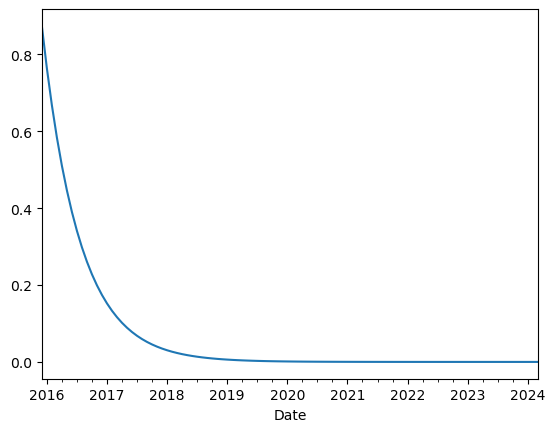

In [37]:
pd.Series(returns,mtl_12.index[:-1]).cumprod().plot()

In [38]:
s_p500=yf.download('^GSPC',start=start).Close

[*********************100%%**********************]  1 of 1 completed


In [39]:
s_p500

Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
                 ...     
2024-04-01    5243.770020
2024-04-02    5205.810059
2024-04-03    5211.490234
2024-04-04    5147.209961
2024-04-05    5204.339844
Name: Close, Length: 2330, dtype: float64